In [1]:
import os
import pickle
import cv2
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm
from PIL import Image

In [16]:
import pandas as pd
dpath = 'C:/Users/minki/Desktop/2022CUAI_winter/'
data = pd.read_csv(dpath + 'metadata.csv')

In [17]:
images_dir_path = os.path.join(dpath, 'emotion_album_images/angry')

In [8]:
def draw_color_histogram_from_image(file_path):
    image_path = file_path#이미지 경로 넣어주기
    img = Image.open(file_path)
    cv_image = cv2.imread(image_path)
    
    #image 시각화
    f = plt.figure(figsize=(10,3))
    im1 = f.add_subplot(1,2,1)
    im1.grid(False)
    im1.imshow(img)
    im1.set_title("Image")
    
    #Histogram 시각화
    im2 = f.add_subplot(1,2,2)
    color = ('b','g','r')
    for i, col in enumerate(color):
        #image 에서 i번째 채널 히스토그램 뽑아서 (0: blue, 1: green, 2:red)
        histr = cv2.calcHist([cv_image],[i],None, [256],[0,256])
        #채널색상과 맞춰 그래프 그린다.
        im2.plot(histr, color = col)
    
    im2.grid(False)
    im2.set_title("Histogram")

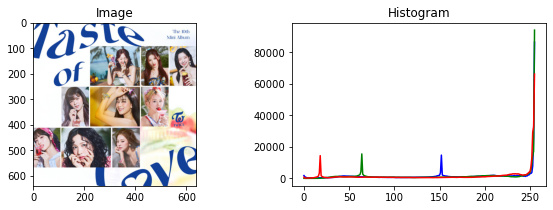

In [9]:
draw_color_histogram_from_image('C:/Users/minki/Desktop/2022CUAI_winter/image2.jpg')

In [13]:
def get_histogram(image):
    histogram = []
    
    for i in range(3):
        channel_histogram = cv2.calcHist(images = [image],
                                        channels= [i],
                                        mask = None,
                                        histSize = [4],#히스토그램 구간을 4개로
                                        ranges = [0,256]
                                        )
        histogram.append(channel_histogram)
    
    histogram = np.concatenate(histogram)
    histogram = cv2.normalize(histogram, histogram)
    
    return histogram

ndarray 로 출력

In [14]:
image = cv2.imread('C:/Users/minki/Desktop/2022CUAI_winter/image2.jpg')
histogram = get_histogram(image)
histogram

array([[0.11636266],
       [0.09773836],
       [0.19330628],
       [0.49698058],
       [0.11561415],
       [0.14783077],
       [0.12377705],
       [0.5171659 ],
       [0.14025077],
       [0.09434029],
       [0.08825731],
       [0.5815395 ]], dtype=float32)

histogram으로 db 만들어준다.

In [18]:
def build_histogram_db():
    histogram_db = {}

    #디렉토리에 모아 둔 이미지 파일들을 전부 가져오자.
    path = images_dir_path
    file_list = os.listdir(images_dir_path)

    for file_name in tqdm(file_list):
        file_path = os.path.join(images_dir_path, file_name)
        image = cv2.imread(file_path)

        histogram = get_histogram(image)

        histogram_db[file_name] = histogram

    return histogram_db

In [19]:
histogram_db = build_histogram_db()
histogram_db['00AeLnDgWSximcIaeoFtpi.jpg']

100%|████████████████████████████████████████████████████████████████████████████| 13206/13206 [03:18<00:00, 66.68it/s]


array([[0.511777  ],
       [0.04920331],
       [0.03201343],
       [0.26097563],
       [0.5114851 ],
       [0.049343  ],
       [0.0321281 ],
       [0.26101315],
       [0.5116477 ],
       [0.04938053],
       [0.03203844],
       [0.26090264]], dtype=float32)

In [24]:
def get_target_histogram():
    filename = input("이미지 파일명을 입력하세요 : ")
    if filename not in histogram_db:
        print('유효하지 않은 이미지 파일명입니다.')
        return None
    return histogram_db[filename]

In [26]:
target_histogram = get_target_histogram()

이미지 파일명을 입력하세요 : 00AeLnDgWSximcIaeoFtpi.jpg


In [27]:
target_histogram

array([[0.511777  ],
       [0.04920331],
       [0.03201343],
       [0.26097563],
       [0.5114851 ],
       [0.049343  ],
       [0.0321281 ],
       [0.26101315],
       [0.5116477 ],
       [0.04938053],
       [0.03203844],
       [0.26090264]], dtype=float32)

In [28]:
def search(histogram_db, target_histogram, top_k = 5):
    results={}
    #simialarity distance 계산 by comparing histograms
    for file_name , histogram in tqdm(histogram_db.items()):
        distance = cv2.compareHist(H1 = target_histogram,
                                  H2 = histogram,
                                  method = cv2.HISTCMP_CHISQR)
        results[file_name]= distance
    results = dict(sorted(results.items(), key=lambda item: item[1])[:top_k])
    
    return results

In [30]:
result = search(histogram_db, target_histogram)
result

100%|████████████████████████████████████████████████████████████████████████| 13206/13206 [00:00<00:00, 363771.15it/s]


{'00AeLnDgWSximcIaeoFtpi.jpg': 0.0,
 '2k4SKTM0a5FVN37VvFbxpr.jpg': 0.03124448185119697,
 '7kUZ9wlY0YkgpG7LSuOgnq.jpg': 0.03457853762202145,
 '7qjA5gbagHWVbqKUgVt49l.jpg': 0.03564653306672554,
 '3WvQpufOsPzkZvcSuynCf3.jpg': 0.04565940473378869}

In [31]:
def show_result(result):
    f=plt.figure(figsize=(10,3))
    for idx, filename in enumerate(result.keys()):    
        img_path = os.path.join(images_dir_path, filename)
        
        im = f.add_subplot(1,len(result),idx+1)
        im.grid(False)
        
        img = Image.open(img_path)
        im.imshow(img)

In [ ]:
target_histogram = get_target_histogram()
result = search(histogram_db, target_histogram)
show_result(result)